In [125]:
import os
import numpy as np
import random
import json
from PIL import Image
from collections import defaultdict
from statistics import mean, stdev
from copy import deepcopy
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import DataLoader
## Torchvision
import torchvision
from torchvision.datasets import CIFAR100, SVHN
from torchvision import transforms
import torchvision.datasets as datasets



# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

C:\Users\fadia\AppData\Local\Temp\ipykernel_18180\2594101905.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 432x288 with 0 Axes>

In [126]:
# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/tutorial16"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Device: cpu


In [127]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial16/"
# Files to download
#"ProtoNet.ckpt", 
pretrained_files = ["ProtoNet.ckpt", "ProtoMAML.ckpt",
                    "tensorboards/ProtoNet/events.out.tfevents.ProtoNet",
                    "tensorboards/ProtoMAML/events.out.tfevents.ProtoMAML",
                    "protomaml_fewshot.json",
                    "protomaml_svhn_fewshot.json"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files[:-2]:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [128]:
CIFAR_train_set = CIFAR100(root=DATASET_PATH, train=True, download=True, transform=transforms.ToTensor())
# Loading CIFAR100 dataset
CIFAR_test_set = CIFAR100(root=DATASET_PATH, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


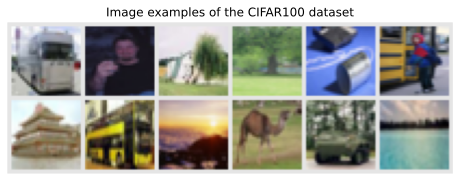

In [129]:
NUM_IMAGES = 12
CIFAR_images = torch.stack([CIFAR_train_set[np.random.randint(len(CIFAR_train_set))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR100 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [130]:
from torch.utils.data import Dataset
import glob
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # Create a dictionary that maps class names to integer labels
        self.class_to_idx = {}
        for i, class_name in enumerate(os.listdir(root_dir)):
            self.class_to_idx[class_name] = i
        
        self.data = []
        for class_name, class_idx in self.class_to_idx.items():
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                path = os.path.join(class_dir, filename)
                img = Image.open(path).convert('RGB')
                img = img.resize((32,32))
                img = np.asarray(img)
                # if self.transform is not None:
                #     img = self.transform(img)
                self.data.append(img)
        
        self.targets = [self.class_to_idx[os.path.basename(os.path.dirname(path))] 
                        for path in glob.glob(os.path.join(root_dir, '*', '*.jpg'))]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.targets[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [131]:
import torch
from torchvision import transforms

# Define the data transformations to be applied to your data
transform = transforms.Compose([
    transforms.ToTensor() # Convert PIL image or numpy.ndarray to tensor
])

# Load your data using the CustomDataset class
train_dataset = CustomDataset(root_dir='./train_flowers/', transform=transform)
val_dataset = CustomDataset(root_dir='./val_flowers/', transform=transform)
test_dataset = CustomDataset(root_dir='./test_flowers/', transform=transform)


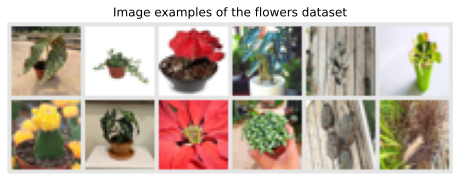

In [132]:
NUM_IMAGES = 12
x = torch.stack([train_dataset[np.random.randint(len(train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(x, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the flowers dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [133]:
len(train_dataset),len(val_dataset),len(test_dataset)

(1602, 226, 467)

In [134]:
all_data = np.concatenate([train_dataset.data, val_dataset.data, test_dataset.data], axis=0)
all_targets = torch.LongTensor(train_dataset.targets + val_dataset.targets + test_dataset.targets)
len(all_data),len(all_targets)

(2295, 2295)

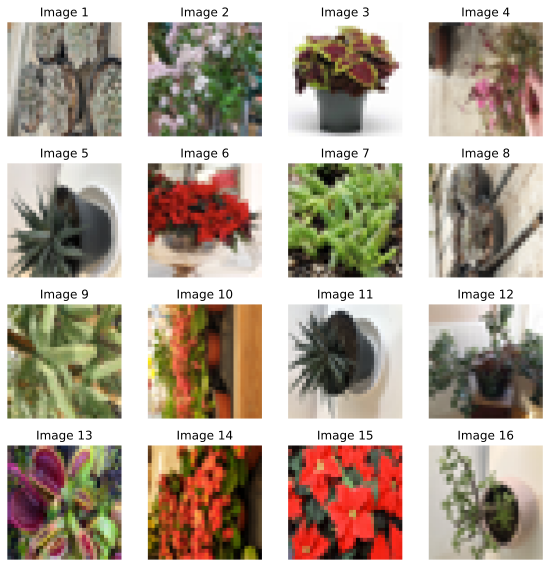

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# select 16 random images from all_data
idxs = np.random.choice(len(all_data), size=16, replace=False)
images = all_data[idxs]

# create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()

# loop over each image and subplot and display the image
for i, (img_tensor, ax) in enumerate(zip(images, axs)):
    # convert tensor to numpy array
    img_array = img_tensor

    # display the image in the subplot
    ax.imshow(img_array)
    ax.set_title(f"Image {i+1}")

# remove the axis labels and adjust the spacing between subplots
for ax in axs:
    ax.set_axis_off()
plt.tight_layout()

# display the plot
plt.show()

In [136]:
class ImageDataset(data.Dataset):

    def __init__(self, imgs, targets, img_transform=None):
        """
        Inputs:
            imgs - Numpy array of shape [N,32,32,3] containing all images.
            targets - PyTorch array of shape [N] containing all labels.
            img_transform - A torchvision transformation that should be applied
                            to the images before returning. If none, no transformation
                            is applied.
        """
        super().__init__()
        self.img_transform = img_transform
        self.imgs = imgs
        self.targets = targets

    def __getitem__(self, idx):
        img, target = self.imgs[idx], self.targets[idx]
        img = Image.fromarray(img)

        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, target

    def __len__(self):
        return self.imgs.shape[0]

In [137]:
torch.manual_seed(0)           # Set seed for reproducibility
classes = torch.randperm(23)  # Returns random permutation of numbers 0 to 99
train_classes, val_classes, test_classes = classes[:15], classes[16:18], classes[18:]
train_classes, val_classes, test_classes

(tensor([19,  8, 16,  3, 15, 20, 22, 14,  4,  7,  6, 13,  9, 10,  1]),
 tensor([ 5, 17]),
 tensor([11,  2, 18,  0, 21]))

In [138]:
# Printing validation and test classes
idx_to_class = {val: key for key, val in train_dataset.class_to_idx.items()}
print("Validation classes:", [idx_to_class[c.item()] for c in val_classes])
print("Test classes:", [idx_to_class[c.item()] for c in test_classes])

Validation classes: ['Elephant_s Ear', 'Poinsettia']
Test classes: ['Moon Cactus', 'Coleus', 'Sansevieria Ballyi', 'Beeblossom', 'woolly senecio']


In [139]:
def dataset_from_labels(imgs, targets, class_set, **kwargs):
    class_mask = (targets[:,None] == class_set[None,:]).any(dim=-1)
    return ImageDataset(imgs=imgs[class_mask],targets=targets[class_mask],**kwargs)

In [140]:
# Pre-computed statistics from the new train set
DATA_MEANS = torch.Tensor([0.5183975 , 0.49192241, 0.44651328])
DATA_STD = torch.Tensor([0.26770132, 0.25828985, 0.27961241])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         DATA_MEANS, DATA_STD)
                                     ])


# For training, we add some augmentation.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop(
                                          (32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          DATA_MEANS, DATA_STD)
                                      ])

train_set = dataset_from_labels(all_data, all_targets, train_classes,img_transform=train_transform)
val_set = dataset_from_labels(all_data, all_targets, val_classes,img_transform=test_transform)
test_set = dataset_from_labels(all_data, all_targets, test_classes,img_transform=test_transform)

In [141]:
len(test_set)

480

In [142]:
class FewShotBatchSampler(object):

    def __init__(self, dataset_targets, N_way, K_shot, include_query=False, shuffle=True, shuffle_once=False):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
            shuffle_once - If True, examples and classes are shuffled once in
                           the beginning, but kept constant across iterations
                           (for validation)
        """
        super().__init__()
        self.dataset_targets = dataset_targets
        self.N_way = N_way
        self.K_shot = K_shot
        self.shuffle = shuffle
        self.include_query = include_query
        if self.include_query:
            self.K_shot *= 2
        self.batch_size = self.N_way * self.K_shot  # Number of overall images per batch

        # Organize examples by class
        self.classes = torch.unique(self.dataset_targets).tolist()
        self.num_classes = len(self.classes)
        self.indices_per_class = {}
        self.batches_per_class = {}  # Number of K-shot batches that each class can provide
        for c in self.classes:
            self.indices_per_class[c] = torch.where(self.dataset_targets == c)[0]
            self.batches_per_class[c] = self.indices_per_class[c].shape[0] // self.K_shot

        # Create a list of classes from which we select the N classes per batch
        self.iterations = sum(self.batches_per_class.values()) // self.N_way
        self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]
        if shuffle_once or self.shuffle:
            self.shuffle_data()
        else:
            # For testing, we iterate over classes instead of shuffling them
            sort_idxs = [i+p*self.num_classes for i,
                         c in enumerate(self.classes) for p in range(self.batches_per_class[c])]
            self.class_list = np.array(self.class_list)[np.argsort(sort_idxs)].tolist()

    def shuffle_data(self):
        # Shuffle the examples per class
        for c in self.classes:
            perm = torch.randperm(self.indices_per_class[c].shape[0])
            self.indices_per_class[c] = self.indices_per_class[c][perm]
        # Shuffle the class list from which we sample. Note that this way of shuffling
        # does not prevent to choose the same class twice in a batch. However, for
        # training and validation, this is not a problem.
        random.shuffle(self.class_list)

    def __iter__(self):
        # Shuffle data
        if self.shuffle:
            self.shuffle_data()

        # Sample few-shot batches
        start_index = defaultdict(int)
        for it in range(self.iterations):
            class_batch = self.class_list[it*self.N_way:(it+1)*self.N_way]  # Select N classes for the batch
            index_batch = []
            for c in class_batch:  # For each class, select the next K examples and add them to the batch
                index_batch.extend(self.indices_per_class[c][start_index[c]:start_index[c]+self.K_shot])
                start_index[c] += self.K_shot
            if self.include_query:  # If we return support+query set, sort them so that they are easy to split
                index_batch = index_batch[::2] + index_batch[1::2]
            yield index_batch

    def __len__(self):
        return self.iterations

In [143]:
N_WAY = 5
K_SHOT = 4
train_data_loader = data.DataLoader(train_set,batch_sampler=FewShotBatchSampler(train_set.targets,include_query=True,N_way=N_WAY,K_shot=K_SHOT,shuffle=True),num_workers=0)
val_data_loader = data.DataLoader(val_set,batch_sampler=FewShotBatchSampler(val_set.targets,include_query=True,N_way=N_WAY,K_shot=K_SHOT,shuffle=False,shuffle_once=True),num_workers=0)

In [144]:
len(train_data_loader)

36

In [145]:
def split_batch(imgs, targets):
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets

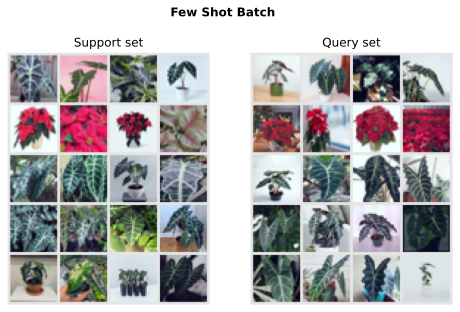

In [146]:
imgs, targets = next(iter(val_data_loader))  # We use the validation set since it does not apply augmentations
support_imgs, query_imgs, _, _ = split_batch(imgs, targets)
support_grid = torchvision.utils.make_grid(support_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
support_grid = support_grid.permute(1, 2, 0)
query_grid = torchvision.utils.make_grid(query_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
query_grid = query_grid.permute(1, 2, 0)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(support_grid)
ax[0].set_title("Support set")
ax[0].axis('off')
ax[1].imshow(query_grid)
ax[1].set_title("Query set")
ax[1].axis('off')
plt.suptitle("Few Shot Batch", weight='bold')
plt.show()
plt.close()

In [147]:
def get_convnet(output_size):
    convnet = torchvision.models.DenseNet(growth_rate=32,
                                          block_config=(6, 6, 6, 6),
                                          bn_size=2,
                                          num_init_features=64,
                                          num_classes=23  # Output dimensionality
                                         )
    return convnet

In [148]:
class ProtoNet(pl.LightningModule):

    def __init__(self, proto_dim, lr):
        """
        Inputs
            proto_dim - Dimensionality of prototype feature space
            lr - Learning rate of Adam optimizer
        """
        super().__init__()
        self.save_hyperparameters()
        self.model = get_convnet(output_size=23)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[140, 180], gamma=0.1)
        return [optimizer], [scheduler]

    @staticmethod
    def calculate_prototypes(features, targets):
        # Given a stack of features vectors and labels, return class prototypes
        # features - shape [N, proto_dim], targets - shape [N]
        classes, _ = torch.unique(targets).sort()  # Determine which classes we have
        prototypes = []
        for c in classes:
            p = features[torch.where(targets == c)[0]].mean(dim=0)  # Average class feature vectors
            prototypes.append(p)
        prototypes = torch.stack(prototypes, dim=0)
        # Return the 'classes' tensor to know which prototype belongs to which class
        return prototypes, classes

    def classify_feats(self, prototypes, classes, feats, targets):
        # Classify new examples with prototypes and return classification error
        dist = torch.pow(prototypes[None, :] - feats[:, None], 2).sum(dim=2)  # Squared euclidean distance
        preds = F.log_softmax(-dist, dim=1)
        labels = (classes[None, :] == targets[:, None]).long().argmax(dim=-1)
        acc = (preds.argmax(dim=1) == labels).float().mean()
        return preds, labels, acc

    def calculate_loss(self, batch, mode):
        # Determine training loss for a given support and query set
        imgs, targets = batch
        features = self.model(imgs)  # Encode all images of support and query set
        support_feats, query_feats, support_targets, query_targets = split_batch(features, targets)
        prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)
        preds, labels, acc = self.classify_feats(prototypes, classes, query_feats, query_targets)
        loss = F.cross_entropy(preds, labels)

        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self.calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        _ = self.calculate_loss(batch, mode="val")

    def classify(self, img_tensor, prototypes, classes):
        # Classify a single image tensor and return predicted class label
        self.eval()
        with torch.no_grad():
            feat = self.model(img_tensor.to(self.device))
            dist = torch.pow(prototypes[None, :] - feat[None, :], 2).sum(dim=2)  # Squared euclidean distance
            preds = F.log_softmax(-dist, dim=1)
            label = torch.take(classes, preds.argmax(dim=1))
        return label.item()
    

    def forward(self, x):
        # Perform forward pass
        features = self.model(x)

        # Apply label assignment
        label_assignment = torch.argmax(features, dim=1)

        return features, label_assignment

In [149]:
# def train_model(model_class, train_loader, val_loader, **kwargs):
#     trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_class.__name__),
#                          accelerator="gpu" if str(device).startswith("cuda") else "cpu",
#                          devices=1,
#                          max_epochs=200,
#                          callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
#                                     LearningRateMonitor("epoch")],
#                          enable_progress_bar=False)
#     trainer.logger._default_hp_metric = None

#     # Check whether pretrained model exists. If yes, load it and skip training
#     pretrained_filename = os.path.join(
#         CHECKPOINT_PATH, model_class.__name__ + ".ckpt")
#     if os.path.isfile(pretrained_filename):
#         print(f"Found pretrained model at {pretrained_filename}, loading...")
#         # Automatically loads the model with the saved hyperparameters
#         model = model_class.load_from_checkpoint(pretrained_filename)
#     else:
#         pl.seed_everything(42)  # To be reproducable
#         model = model_class(**kwargs)
#         trainer.fit(model, train_loader, val_loader)
#         model = model_class.load_from_checkpoint(
#             trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

#     return model

In [150]:
def train_model(model_class, train_loader, val_loader, **kwargs):
    checkpoint_path = "./my_saved_models/"
    trainer = pl.Trainer(
        default_root_dir=checkpoint_path,
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=200,
        callbacks=[
            ModelCheckpoint(
                dirpath=checkpoint_path,
                filename=model_class.__name__ + "-{epoch:02d}-{val_acc:.2f}",
                save_top_k=1,
                monitor="val_acc",
                mode="max",
                save_weights_only=True,
            ),
            LearningRateMonitor("epoch")
        ],
        enable_progress_bar=False
    )
    trainer.logger._default_hp_metric = None
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(
        CHECKPOINT_PATH, model_class.__name__ + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = model_class.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = model_class(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = model_class.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model


In [151]:
CHECKPOINT_PATH

'./saved_models/tutorial16'

In [152]:
# def train_model(model_class, train_loader, val_loader, **kwargs):
#     trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_class.__name__),
#                          accelerator="gpu" if str(device).startswith("cuda") else "cpu",
#                          devices=1,
#                          max_epochs=200,
#                          callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
#                                     LearningRateMonitor("epoch")],
#                          enable_progress_bar=False)
#     trainer.logger._default_hp_metric = None


#     # Check whether pretrained model exists. If yes, load it and skip training
#     pretrained_filename = os.path.join(CHECKPOINT_PATH, model_class.__name__ + ".ckpt")
#     #Check if my trained models exist, if yes, load and skip pre trained models
#     myTrained_filename = os.path.join(CHECKPOINT_PATH, "my" + model_class.__name__ + ".pt")


#     if os.path.isfile(myTrained_filename):
#         print(f"Found your model at model at {myTrained_filename}, loading...")
#         # Automatically loads the model with the saved hyperparameters
#         # To load the saved model:
#         state_dict  = torch.load(myTrained_filename)
#         # Load the state dictionary into the model
#         protonet_model.load_state_dict(state_dict)



#     elif os.path.isfile(pretrained_filename):
#         print(f"Found pretrained model at {pretrained_filename}, loading...")
#         # Automatically loads the model with the saved hyperparameters
#         model = model_class.load_from_checkpoint(pretrained_filename)
#     else:
#         pl.seed_everything(42)  # To be reproducable
#         model = model_class(**kwargs)
#         trainer.fit(model, train_loader, val_loader)
#         model = model_class.load_from_checkpoint(
#             trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

#     return model

In [153]:
# protonet_model = train_model(ProtoNet,
#                              proto_dim=64,
#                              lr=2e-4,
#                              train_loader=train_data_loader,
#                              val_loader=val_data_loader)

In [154]:
CHECKPOINT_PATH="./my_saved_models/"
protonet_model = train_model(ProtoNet,
                             train_loader=train_data_loader,
                             val_loader=val_data_loader,
                             proto_dim=64,
                             lr=2e-4)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ./my_saved_models/ProtoNet.ckpt, loading...


In [155]:
# # Save the trained model as ONNX
# dummy_input = torch.randn(1, 3, 128, 128)  # Create a dummy input tensor
# onnx_path = "model.onnx"  # Path to save the ONNX model
# torch.onnx.export(protonet_model, dummy_input, onnx_path, verbose=True)

In [156]:
# CHECKPOINT_PATH = "./my_saved_models/saved_model.pt"
# torch.save(protonet_model.state_dict(), CHECKPOINT_PATH)

In [157]:
# model = ProtoNet(proto_dim=64,lr=2e-4)
# model.load_state_dict(torch.load(CHECKPOINT_PATH))
# model.eval()

In [158]:
# # Save the model checkpoint
# checkpoint_path = os.path.join(CHECKPOINT_PATH, "my"+ProtoNet.__name__+".pt")
# torch.save(protonet_model.state_dict(), checkpoint_path)

In [159]:
%tensorboard --logdir ../saved_models/tutorial16/tensorboards/ProtoNet/

Reusing TensorBoard on port 6006 (pid 13384), started 6 days, 9:43:08 ago. (Use '!kill 13384' to kill it.)

In [160]:
@torch.no_grad()
def test_proto_net(model, dataset, data_feats=None, k_shot=4):
    """
    Inputs
        model - Pretrained ProtoNet model
        dataset - The dataset on which the test should be performed.
                  Should be instance of ImageDataset
        data_feats - The encoded features of all images in the dataset.
                     If None, they will be newly calculated, and returned
                     for later usage.
        k_shot - Number of examples per class in the support set.
    """
    model = model.to(device)
    model.eval()
    num_classes = dataset.targets.unique().shape[0]
    exmps_per_class = dataset.targets.shape[0]//num_classes  # We assume uniform example distribution here
    # The encoder network remains unchanged across k-shot settings. Hence, we only need
    # to extract the features for all images once.
    if data_feats is None:
        # Dataset preparation
        dataloader = data.DataLoader(dataset, batch_size=128, num_workers=0, shuffle=False, drop_last=False)
        img_features = []
        img_targets = []
        count=1
        img_list = []
        for imgs, targets in tqdm(dataloader, "Extracting image features", leave=False):
            count+=1
            imgs = imgs.to(device)
            feats = model.model(imgs)
            img_features.append(feats.detach().cpu())
            img_targets.append(targets)
        img_features = torch.cat(img_features, dim=0)
        img_targets = torch.cat(img_targets, dim=0)
        # Sort by classes, so that we obtain tensors of shape [num_classes, exmps_per_class, ...]
        # Makes it easier to process later
        img_targets, sort_idx = img_targets.sort()
        img_targets = img_targets.reshape(num_classes, exmps_per_class).transpose(0, 1)
        img_features = img_features[sort_idx].reshape(num_classes, exmps_per_class, -1).transpose(0, 1)
    else:
        img_features, img_targets = data_feats

    #print(f'img_features shape: {img_features.shape}')
    #print(f'img_targets shape: {img_targets.shape}')
    
    # We iterate through the full dataset in two manners. First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples
    accuracies = []
    for k_idx in tqdm(range(0, img_features.shape[0], k_shot), "Evaluating prototype classification", leave=False):
        # Select support set and calculate prototypes
        k_img_feats, k_targets = img_features[k_idx:k_idx+k_shot].flatten(0,1), img_targets[k_idx:k_idx+k_shot].flatten(0,1)
        prototypes, proto_classes = model.calculate_prototypes(k_img_feats, k_targets)

        #_, _, acc = model.classify_feats(prototypes, proto_classes, e_img_feats, e_targets)
        # Evaluate accuracy on the rest of the dataset
        batch_acc = 0
        for e_idx in range(0, img_features.shape[0], k_shot):
            if k_idx == e_idx:  # Do not evaluate on the support set examples
                continue
            e_img_feats, e_targets = img_features[e_idx:e_idx+k_shot].flatten(0,1), img_targets[e_idx:e_idx+k_shot].flatten(0,1)
            _, _, acc = model.classify_feats(prototypes, proto_classes, e_img_feats, e_targets)
            batch_acc += acc.item()
            
            #print(f'Batch acc: {batch_acc}')

        batch_acc /= img_features.shape[0]//k_shot-1
        accuracies.append(batch_acc)
        #print(f"k_idx:{k_idx} batch_acc:{batch_acc} accuracies:{accuracies}")


    return (mean(accuracies), stdev(accuracies)), (img_features, img_targets)

In [161]:
classes_to_labels={'Beeblossom': 0,
                'Begonia Maculata': 1,
                'Coleus': 2,
                'Crown of thorns': 3,
                'echeveria': 4,
                'Elephant_s Ear': 5,
                'House Leek': 6,
                'Jade Plant': 7,
                'Limonium sinuatum': 8,
                'Lucky Bamboo': 9,
                'Mesquites': 10,
                'Moon Cactus': 11,
                'Myoporum': 12,
                'Nerve Plant': 13,
                'Paddle Plant': 14,
                'Parlor Palm': 15,
                'Pennisetum': 16,
                'Poinsettia': 17,
                'Sansevieria Ballyi': 18,
                'String Of Banana': 19,
                'Venus Fly Trap': 20,
                'woolly senecio': 21,
                'Zebra Cactus': 22}

In [162]:
def classify_single_image(model, dataset, img_path, data_feats=None):

    torch.manual_seed(0)

    model = model.to(device)
    model.eval()

    # Extract image features
    if data_feats is None:
        DATA_MEANS = torch.Tensor([0.5183975 , 0.49192241, 0.44651328])
        DATA_STD = torch.Tensor([0.26770132, 0.25828985, 0.27961241])
        transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop(
                                          (32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          DATA_MEANS, DATA_STD)
                                      ])
        img = Image.open(img_path)
        img_tensor = transform(img).unsqueeze(0).to(device)

        dataloader = data.DataLoader(dataset, batch_size=128, num_workers=0, shuffle=False, drop_last=False)
        img_features = []
        img_targets = []
        for imgs, targets in tqdm(dataloader, "Extracting image features", leave=False):
            imgs = imgs.to(device)
            feats = model.model(imgs)
            img_features.append(feats.detach().cpu())
            img_targets.append(targets)
        img_features = torch.cat(img_features, dim=0)
        img_targets = torch.cat(img_targets, dim=0)

        # Calculate prototypes and prototype classes
        prototypes, proto_classes = model.calculate_prototypes(img_features, img_targets)
        # Save prototypes and proto_classes to a file
        CHECKPOINT_PATH = "./my_saved_models/prototypes.pt"
        torch.save({'prototypes': prototypes, 'proto_classes': proto_classes}, CHECKPOINT_PATH)
    else:
        img_tensor = None
        img_features, img_targets = data_feats
        prototypes, proto_classes = model.calculate_prototypes(img_features, img_targets)

    # Classify image
    label = model.classify(img_tensor, prototypes, proto_classes)
    # Print the predicted class index
    print("Predicted class:", next(key for key, value in classes_to_labels.items() if value == label))

In [163]:
# import torch
# from torchvision import transforms
# from PIL import Image

# # Set device
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Define preprocess_image function
# def preprocess_image(img_path):
#     model = model.to(device)
#     model.eval()

#     DATA_MEANS = torch.Tensor([0.5183975 , 0.49192241, 0.44651328])
#     DATA_STD = torch.Tensor([0.26770132, 0.25828985, 0.27961241])
#     transform = transforms.Compose([transforms.RandomHorizontalFlip(),
#                                     transforms.RandomResizedCrop(
#                                         (128, 128), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
#                                     transforms.ToTensor(),
#                                     transforms.Normalize(
#                                         DATA_MEANS, DATA_STD)
#                                     ])
#     img = Image.open(img_path)
#     img_tensor = transform(img).unsqueeze(0).to(device)

#     return img_tensor

In [164]:
from torch.utils.data import ConcatDataset

# concatenate the train_set, val_set and test_set
concat_dataset = ConcatDataset([train_set, val_set, test_set])

In [165]:
classify_single_image(protonet_model, concat_dataset, r"test_flowers\Beeblossom\20211212_122123(0).jpg")

Extracting image features:   0%|          | 0/18 [00:00<?, ?it/s]

Predicted class: Beeblossom


In [166]:
# import torch

# # assume your trained model is stored in a variable called protonet_model
# # and you want to save it to a file named protonet_model.pt
# torch.save(protonet_model.state_dict(), "protonet_model.pt")

In [167]:
protonet_accuracies = dict()
data_feats = None
for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    #print(f"Testing with k={k}")
    protonet_accuracies[k], data_feats = test_proto_net(protonet_model, test_set, data_feats=data_feats, k_shot=k)
    print(f"Accuracy for k={k}: {100.0*protonet_accuracies[k][0]:4.2f}% (+-{100*protonet_accuracies[k][1]:4.2f}%)")

Extracting image features:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating prototype classification:   0%|          | 0/96 [00:00<?, ?it/s]

Accuracy for k=1: 54.97% (+-7.92%)


Evaluating prototype classification:   0%|          | 0/48 [00:00<?, ?it/s]

Accuracy for k=2: 58.64% (+-6.51%)


Evaluating prototype classification:   0%|          | 0/32 [00:00<?, ?it/s]

Accuracy for k=3: 62.57% (+-5.58%)


Evaluating prototype classification:   0%|          | 0/24 [00:00<?, ?it/s]

Accuracy for k=4: 63.39% (+-5.75%)


Evaluating prototype classification:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy for k=5: 67.39% (+-7.23%)


Evaluating prototype classification:   0%|          | 0/16 [00:00<?, ?it/s]

Accuracy for k=6: 65.64% (+-3.67%)


Evaluating prototype classification:   0%|          | 0/14 [00:00<?, ?it/s]

Accuracy for k=7: 71.39% (+-4.69%)


Evaluating prototype classification:   0%|          | 0/12 [00:00<?, ?it/s]

Accuracy for k=8: 66.29% (+-3.13%)


Evaluating prototype classification:   0%|          | 0/11 [00:00<?, ?it/s]

Accuracy for k=9: 74.84% (+-2.99%)


Evaluating prototype classification:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy for k=10: 74.83% (+-3.85%)


In [168]:
def plot_few_shot(acc_dict, name, color=None, ax=None):
    sns.set()
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,3))
    ks = sorted(list(acc_dict.keys()))
    mean_accs = [acc_dict[k][0] for k in ks]
    std_accs = [acc_dict[k][1] for k in ks]
    ax.plot(ks, mean_accs, marker='o', markeredgecolor='k', markersize=6, label=name, color=color)
    ax.fill_between(ks, [m-s for m,s in zip(mean_accs, std_accs)], [m+s for m,s in zip(mean_accs, std_accs)], alpha=0.2, color=color)
    ax.set_xticks(ks)
    ax.set_xlim([ks[0]-1, ks[-1]+1])
    ax.set_xlabel("Number of shots per class", weight='bold')
    ax.set_ylabel("Accuracy", weight='bold')
    if len(ax.get_title()) == 0:
        ax.set_title("Few-Shot Performance " + name, weight='bold')
    else:
        ax.set_title(ax.get_title() + " and " + name, weight='bold')
    ax.legend()
    return ax

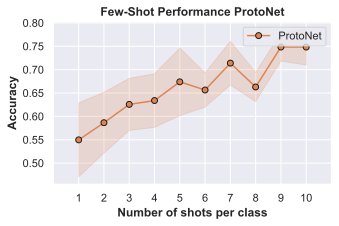

In [169]:
ax = plot_few_shot(protonet_accuracies, name="ProtoNet", color="C1")
plt.show()
plt.close()

In [170]:
# full_test_set = dataset_from_labels(np.array(test_dataset.data),torch.LongTensor(test_dataset.targets),torch.LongTensor(test_dataset.targets),img_transform=test_transform)
# len(full_test_set)

In [171]:
# import os

# # Set the path to the folder containing the class folders
# data_path = r"./test_flowers/"

# # Loop over the class folders
# for class_folder in os.listdir(data_path):
#     # Get the path to the class folder
#     class_path = os.path.join(data_path, class_folder)
#     # Count the number of images in the class folder
#     num_images = len(os.listdir(class_path))
#     # Print the class name and the number of images
#     print(f"Class {class_folder} has {num_images} images")

In [172]:
# #modify the test set to have 19 images per class
# def modify_data_set(dataset):
#     new_imgs = []
#     new_targets = []
#     max_images_per_class = 19

#     for c in np.unique(dataset.targets):
#         class_images = dataset.imgs[dataset.targets == c]
#         class_targets = dataset.targets[dataset.targets == c]

#         if len(class_images) > max_images_per_class:
#             # randomly select max_images_per_class images from this class
#             selected_indices = np.random.choice(len(class_images), size=max_images_per_class, replace=False)
#             class_images = class_images[selected_indices]
#             class_targets = class_targets[selected_indices]

#         new_imgs.append(class_images)
#         new_targets.append(class_targets)

#     new_imgs = np.concatenate(new_imgs)
#     new_targets = np.concatenate(new_targets)

#     modified_dataset = ImageDataset(new_imgs, torch.LongTensor(new_targets), img_transform=dataset.img_transform)
#     return modified_dataset

In [173]:
# modify_data_set=modify_data_set(full_test_set)

In [174]:
# protonet_accuracies = dict()
# data_feats = None
# for k in [1, 2, 3, 4, 5,6,7,8]:
#     #print(f"Testing with k={k}")
#     protonet_accuracies[k], data_feats = test_proto_net(protonet_model, modify_data_set, data_feats=data_feats, k_shot=k)
#     print(f"Accuracy for k={k}: {100.0*protonet_accuracies[k][0]:4.2f}% (+-{100*protonet_accuracies[k][1]:4.2f}%)")

In [175]:
# def plot_few_shot(acc_dict, name, color=None, ax=None):
#     sns.set()
#     if ax is None:
#         fig, ax = plt.subplots(1,1,figsize=(5,3))
#     ks = sorted(list(acc_dict.keys()))
#     mean_accs = [acc_dict[k][0] for k in ks]
#     std_accs = [acc_dict[k][1] for k in ks]
#     ax.plot(ks, mean_accs, marker='o', markeredgecolor='k', markersize=6, label=name, color=color)
#     ax.fill_between(ks, [m-s for m,s in zip(mean_accs, std_accs)], [m+s for m,s in zip(mean_accs, std_accs)], alpha=0.2, color=color)
#     ax.set_xticks(ks)
#     ax.set_xlim([ks[0]-1, ks[-1]+1])
#     ax.set_xlabel("Number of shots per class", weight='bold')
#     ax.set_ylabel("Accuracy", weight='bold')
#     if len(ax.get_title()) == 0:
#         ax.set_title("Few-Shot Performance " + name, weight='bold')
#     else:
#         ax.set_title(ax.get_title() + " and " + name, weight='bold')
#     ax.legend()
#     return ax

In [176]:
# ax = plot_few_shot(protonet_accuracies, name="ProtoNet", color="C1")
# plt.show()
# plt.close()

Protonet + MAML

In [177]:
class ProtoMAML(pl.LightningModule):

    def __init__(self, proto_dim, lr, lr_inner, lr_output, num_inner_steps):
        """
        Inputs
            proto_dim - Dimensionality of prototype feature space
            lr - Learning rate of the outer loop Adam optimizer
            lr_inner - Learning rate of the inner loop SGD optimizer
            lr_output - Learning rate for the output layer in the inner loop
            num_inner_steps - Number of inner loop updates to perform
        """
        super().__init__()
        self.save_hyperparameters()
        self.model = get_convnet(output_size=self.hparams.proto_dim)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[140,180], gamma=0.1)
        return [optimizer], [scheduler]

    def run_model(self, local_model, output_weight, output_bias, imgs, labels):
        # Execute a model with given output layer weights and inputs
        feats = local_model(imgs)
        preds = F.linear(feats, output_weight, output_bias)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=1) == labels).float()
        return loss, preds, acc

    def adapt_few_shot(self, support_imgs, support_targets):
        # Determine prototype initialization
        support_feats = self.model(support_imgs)
        prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)
        support_labels = (classes[None,:] == support_targets[:,None]).long().argmax(dim=-1)
        # Create inner-loop model and optimizer
        local_model = deepcopy(self.model)
        local_model.train()
        local_optim = optim.SGD(local_model.parameters(), lr=self.hparams.lr_inner)
        local_optim.zero_grad()
        # Create output layer weights with prototype-based initialization
        init_weight = 2 * prototypes
        init_bias = -torch.norm(prototypes, dim=1)**2
        output_weight = init_weight.detach().requires_grad_()
        output_bias = init_bias.detach().requires_grad_()

        # Optimize inner loop model on support set
        for _ in range(self.hparams.num_inner_steps):
            # Determine loss on the support set
            loss, _, _ = self.run_model(local_model, output_weight, output_bias, support_imgs, support_labels)
            # Calculate gradients and perform inner loop update
            loss.backward()
            local_optim.step()
            # Update output layer via SGD
            output_weight.data -= self.hparams.lr_output * output_weight.grad
            output_bias.data -= self.hparams.lr_output * output_bias.grad
            # Reset gradients
            local_optim.zero_grad()
            output_weight.grad.fill_(0)
            output_bias.grad.fill_(0)

        # Re-attach computation graph of prototypes
        output_weight = (output_weight - init_weight).detach() + init_weight
        output_bias = (output_bias - init_bias).detach() + init_bias

        return local_model, output_weight, output_bias, classes

    def outer_loop(self, batch, mode="train"):
        accuracies = []
        losses = []
        self.model.zero_grad()

        # Determine gradients for batch of tasks
        for task_batch in batch:
            imgs, targets = task_batch
            support_imgs, query_imgs, support_targets, query_targets = split_batch(imgs, targets)
            # Perform inner loop adaptation
            local_model, output_weight, output_bias, classes = self.adapt_few_shot(support_imgs, support_targets)
            # Determine loss of query set
            query_labels = (classes[None,:] == query_targets[:,None]).long().argmax(dim=-1)
            loss, preds, acc = self.run_model(local_model, output_weight, output_bias, query_imgs, query_labels)
            # Calculate gradients for query set loss
            if mode == "train":
                loss.backward()

                for p_global, p_local in zip(self.model.parameters(), local_model.parameters()):
                    p_global.grad += p_local.grad  # First-order approx. -> add gradients of finetuned and base model

            accuracies.append(acc.mean().detach())
            losses.append(loss.detach())

        # Perform update of base model
        if mode == "train":
            opt = self.optimizers()
            opt.step()
            opt.zero_grad()

        self.log(f"{mode}_loss", sum(losses) / len(losses))
        self.log(f"{mode}_acc", sum(accuracies) / len(accuracies))

    def training_step(self, batch, batch_idx):
        self.outer_loop(batch, mode="train")
        return None  # Returning None means we skip the default training optimizer steps by PyTorch Lightning

    def validation_step(self, batch, batch_idx):
        # Validation requires to finetune a model, hence we need to enable gradients
        torch.set_grad_enabled(True)
        self.outer_loop(batch, mode="val")
        torch.set_grad_enabled(False)

In [178]:
class TaskBatchSampler(object):

    def __init__(self, dataset_targets, batch_size, N_way, K_shot, include_query=False, shuffle=True):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            batch_size - Number of tasks to aggregate in a batch
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
        """
        super().__init__()
        self.batch_sampler = FewShotBatchSampler(dataset_targets, N_way, K_shot, include_query, shuffle)
        self.task_batch_size = batch_size
        self.local_batch_size = self.batch_sampler.batch_size

    def __iter__(self):
        # Aggregate multiple batches before returning the indices
        batch_list = []
        for batch_idx, batch in enumerate(self.batch_sampler):
            batch_list.extend(batch)
            if (batch_idx+1) % self.task_batch_size == 0:
                yield batch_list
                batch_list = []

    def __len__(self):
        return len(self.batch_sampler)//self.task_batch_size

    def get_collate_fn(self):
        # Returns a collate function that converts one big tensor into a list of task-specific tensors
        def collate_fn(item_list):
            imgs = torch.stack([img for img, target in item_list], dim=0)
            targets = torch.stack([target for img, target in item_list], dim=0)
            imgs = imgs.chunk(self.task_batch_size, dim=0)
            targets = targets.chunk(self.task_batch_size, dim=0)
            return list(zip(imgs, targets))
        return collate_fn

In [179]:
# Training constant (same as for ProtoNet)
N_WAY = 5
K_SHOT = 4

# Training set
train_protomaml_sampler = TaskBatchSampler(train_set.targets,
                                           include_query=True,
                                           N_way=N_WAY,
                                           K_shot=K_SHOT,
                                           batch_size=16)
train_protomaml_loader = data.DataLoader(train_set,
                                         batch_sampler=train_protomaml_sampler,
                                         collate_fn=train_protomaml_sampler.get_collate_fn(),
                                         num_workers=0)

# Validation set
val_protomaml_sampler = TaskBatchSampler(val_set.targets,
                                         include_query=True,
                                         N_way=N_WAY,
                                         K_shot=K_SHOT,
                                         batch_size=1,  # We do not update the parameters, hence the batch size is irrelevant here
                                         shuffle=False)
val_protomaml_loader = data.DataLoader(val_set,
                                       batch_sampler=val_protomaml_sampler,
                                       collate_fn=val_protomaml_sampler.get_collate_fn(),
                                       num_workers=0)

In [180]:
protomaml_model = train_model(ProtoMAML, 
                              train_loader=train_protomaml_loader, 
                              val_loader=val_protomaml_loader, 
                              proto_dim=32,
                              lr=1e-3,
                              lr_inner=0.1,
                              lr_output=0.1,
                              num_inner_steps=1)  # Often values between 1 and 10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at ./my_saved_models/ProtoMAML.ckpt, loading...


In [181]:
# # Save the model checkpoint
# checkpoint_path = os.path.join(CHECKPOINT_PATH, "my"+ProtoMAML.__name__+".pt")
# torch.save(protomaml_model.state_dict(), checkpoint_path)

In [182]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH if needed
%tensorboard --logdir ../saved_models/tutorial16/tensorboards/ProtoMAML/

Reusing TensorBoard on port 6006 (pid 13804), started 1 day, 23:44:52 ago. (Use '!kill 13804' to kill it.)

In [183]:
def test_protomaml(model, dataset, k_shot=4):
    pl.seed_everything(42)
    model = model.to(device)
    num_classes = dataset.targets.unique().shape[0]
    exmps_per_class = dataset.targets.shape[0]//num_classes

    # Data loader for full test set as query set
    full_dataloader = data.DataLoader(dataset,
                                      batch_size=128,
                                      num_workers=0,
                                      shuffle=False,
                                      drop_last=False)
    # Data loader for sampling support sets
    sampler = FewShotBatchSampler(dataset.targets,
                                  include_query=False,
                                  N_way=num_classes,
                                  K_shot=k_shot,
                                  shuffle=False,
                                  shuffle_once=False)
    sample_dataloader = data.DataLoader(dataset,
                                        batch_sampler=sampler,
                                        num_workers=0)

    # We iterate through the full dataset in two manners. First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples
    accuracies = []
    for (support_imgs, support_targets), support_indices in tqdm(zip(sample_dataloader, sampler), "Performing few-shot finetuning"):
        support_imgs = support_imgs.to(device)
        support_targets = support_targets.to(device)
        # Finetune new model on support set
        local_model, output_weight, output_bias, classes = model.adapt_few_shot(support_imgs, support_targets)
        with torch.no_grad():  # No gradients for query set needed
            local_model.eval()
            batch_acc = torch.zeros((0,), dtype=torch.float32, device=device)
            # Evaluate all examples in test dataset
            for query_imgs, query_targets in full_dataloader:
                query_imgs = query_imgs.to(device)
                query_targets = query_targets.to(device)
                query_labels = (classes[None,:] == query_targets[:,None]).long().argmax(dim=-1)
                _, _, acc = model.run_model(local_model, output_weight, output_bias, query_imgs, query_labels)
                batch_acc = torch.cat([batch_acc, acc.detach()], dim=0)
            # Exclude support set elements
            for s_idx in support_indices:
                batch_acc[s_idx] = 0
            batch_acc = batch_acc.sum().item() / (batch_acc.shape[0] - len(support_indices))
            accuracies.append(batch_acc)
    return mean(accuracies), stdev(accuracies)

In [184]:
protomaml_result_file = os.path.join(CHECKPOINT_PATH, "protomaml_fewshot.json")

if os.path.isfile(protomaml_result_file):
    # Load pre-computed results
    with open(protomaml_result_file, 'r') as f:
        protomaml_accuracies = json.load(f)
    protomaml_accuracies = {int(k): v for k, v in protomaml_accuracies.items()}
else:
    # Perform same experiments as for ProtoNet
    print("here")
    protomaml_accuracies = dict()
    for k in [1, 2, 3, 4,5,6,7,8,9,10]:
        protomaml_accuracies[k] = test_protomaml(protomaml_model, test_set, k_shot=k)
    # Export results
    with open(protomaml_result_file, 'w') as f:
        json.dump(protomaml_accuracies, f, indent=4)

for k in protomaml_accuracies:
    print(f"Accuracy for k={k}: {100.0*protomaml_accuracies[k][0]:4.2f}% (+-{100.0*protomaml_accuracies[k][1]:4.2f}%)")

Global seed set to 42


here


Performing few-shot finetuning: 0it [00:00, ?it/s]

Global seed set to 42


Performing few-shot finetuning: 0it [00:00, ?it/s]

Global seed set to 42


Performing few-shot finetuning: 0it [00:00, ?it/s]

Global seed set to 42


Performing few-shot finetuning: 0it [00:00, ?it/s]

Global seed set to 42


Performing few-shot finetuning: 0it [00:00, ?it/s]

Global seed set to 42


Performing few-shot finetuning: 0it [00:00, ?it/s]

Global seed set to 42


Performing few-shot finetuning: 0it [00:00, ?it/s]

Global seed set to 42


Performing few-shot finetuning: 0it [00:00, ?it/s]

Global seed set to 42


Performing few-shot finetuning: 0it [00:00, ?it/s]

Global seed set to 42


Performing few-shot finetuning: 0it [00:00, ?it/s]

Accuracy for k=1: 47.38% (+-6.85%)
Accuracy for k=2: 54.43% (+-7.19%)
Accuracy for k=3: 59.02% (+-7.29%)
Accuracy for k=4: 60.66% (+-6.43%)
Accuracy for k=5: 61.62% (+-4.82%)
Accuracy for k=6: 65.19% (+-6.42%)
Accuracy for k=7: 65.69% (+-4.95%)
Accuracy for k=8: 66.86% (+-5.52%)
Accuracy for k=9: 66.02% (+-5.53%)
Accuracy for k=10: 67.60% (+-4.56%)


In [185]:
CHECKPOINT_PATH

'./my_saved_models/'

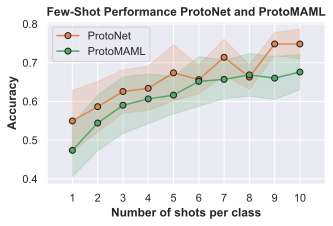

In [186]:
ax = plot_few_shot(protonet_accuracies, name="ProtoNet", color="C1")
plot_few_shot(protomaml_accuracies, name="ProtoMAML", color="C2", ax=ax)
plt.show()
plt.close()